In [2]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

#### __Overall Steps__
#### 1.   Read and Format Data
#### 2.   Data Preprocessing and Cleaning
#### 3.   Sentiment Analysis
#### 4.   Exploratory Data Analysis
#### 4.1. Word Frequencies
#### 5.   Topic Modeling

In [1]:
from collections import Counter
import json, string
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import contractions
import pyLDAvis.sklearn
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

## Read and Format Data

#### __This section includes:__
#### - reading the data
#### - formatting date column
#### - altering stars field to range from 1 to 5

In [3]:
f = open('../data/train_reviews.json')
df = pd.DataFrame(json.load(f))
df

,date,title,text,url,stars
0,2015-10-10T14:32:51.000+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22T17:04:56.000+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13T23:37:05.000+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
3,2015-01-13T12:26:52.000+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
4,2011-05-28T15:00:36.000+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
...,...,...,...,...,...
2016,2017-07-06T20:20:58.000+00:00,Late,"Late, cancelled, signal failures, too much rai...",https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-1 star-rating--medium
2017,2016-11-29T10:26:41.000+00:00,Not sure why they even have timetables,Trains are constantly delayed or cancelled. I ...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-1 star-rating--medium
2018,2016-07-17T07:42:11.000+00:00,Helpful guards,On a yearly basis we take a group of Preschool...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-5 star-rating--medium
2019,2016-05-22T12:25:51.000+00:00,Often late but clean and decent.,I travel by them every day. I like their newis...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-3 star-rating--medium


In [3]:
def format_data(df):
    # Change "date" column type from string to datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    
    # Sort entries by "date" column
    df.sort_values(by='date', inplace=True)
    
    # Extract level of star and assign it as integer
    df['stars'] = df['stars'].apply(lambda x: int(x[24]))
    
    # Drop duplicate rows with same content in "text" column
    df.drop_duplicates(subset='text', inplace=True)
    df = df.reset_index(drop=True)
    
    # df['title_text'] = df[['title', 'text']].agg(' '.join, axis=1)
    
    # For this task I chose to remove "url" field since there can not be any use of it
    del df['url']
    
    return df

def read_format():
    f = open('../data/train_reviews.json')
    df = pd.DataFrame(json.load(f))
    return df

df = read_format()
df = format_data(df)
df

,date,title,text,stars
0,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,4
1,2011-11-20 20:43:09+00:00,"Reasonable prices, good service","First class is very spacious, free wireless in...",4
2,2015-01-07 23:32:34+00:00,Fantastic customer service,Virgin trains customer service are amazing,5
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,4
4,2015-02-11 13:20:32+00:00,Best customer service,I was at traveling back to Coventry from Wolve...,5
...,...,...,...,...
1432,2018-07-16 21:44:46+00:00,Overcrowded shoddy service,A very poor service on the Chester to Manchest...,1
1433,2018-07-17 08:51:36+00:00,the day we do not have delays in the…,the day we do not have delays in the SWR train...,1
1434,2018-07-17 08:54:14+00:00,Terrible service,Terrible service,1
1435,2018-07-17 09:32:06+00:00,No stars would be more appropriate.,No stars would be more appropriate.,1


In [4]:
df.isna().sum()

date     0
title    0
text     0
stars    0
dtype: int64

#### _Discussion Point 1: Could "title" and "text" fields be combined? If so, how would it affect the flow?_
#### _Discussion Point 2: Do "date" and "stars" fields have positive/negative correlation? Would it change the perspective of the data? In addition to that, could a __time-series__ model be applied to this task?_

## Data Preprocessing

#### __This section includes data preprocessing steps:__
#### - Expanding Contractions
#### - Removing punctuations
#### - Tokenization
#### - Text Lowecase
#### - Remove Stopwords
#### - POS Tagging
#### - Lemmatization

In [5]:
# Expand contractions: I'm -> I + am, you're -> you + are, ...
print("Sample contractions: ", list(contractions.contractions_dict)[:5])
df['contractions_expanded'] = df['text'].apply(lambda x: " ".join(map(str, [contractions.fix(word) for word in x.split()])))

punct_digit = string.punctuation + string.digits + "£"
print("Sample punctuations: ", punct_digit)
def remove_punctuations(text):
    for punct in punct_digit:
        text = text.replace(punct, '')
    return text
df["punctuations_removed"] = df['contractions_expanded'].apply(remove_punctuations)

# NLTK Tokenization
df['tokenized'] = df['punctuations_removed'].apply(word_tokenize)

# Lowercase Text
df['tokenized_lowered'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

# Remove Stopwords
stop_words = set(stopwords.words('english'))
df['tokenized_lowered_stopword_removed'] = df['tokenized_lowered'].apply(lambda x: [word for word in x if word not in stop_words])

# Remove tokens with length only 1
df['tokenized_lowered_stopword_removed'] = df['tokenized_lowered_stopword_removed'].apply(lambda x: [word for word in x if len(word) > 1])

# POS tagging
df['pos_tag'] = df['tokenized_lowered_stopword_removed'].apply(nltk.tag.pos_tag)

def wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Wordnet POS tagging
df['wordnet'] = df['pos_tag'].apply(lambda x: [(word, wordnet_pos(pos_tag)) for (word, pos_tag) in x])

# Lemmatization
word_net_lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['wordnet'].apply(lambda x: [word_net_lemmatizer.lemmatize(word, wordnet_tag) for word, wordnet_tag in x])

df

Sample contractions:  ["I'm", "I'm'a", "I'm'o", "I've", "I'll"]
Sample punctuations:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789£


,date,title,text,stars,contractions_expanded,punctuations_removed,tokenized,tokenized_lowered,tokenized_lowered_stopword_removed,pos_tag,wordnet,lemmatized
0,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,4,I always use the national rail enquiry site wh...,I always use the national rail enquiry site wh...,"[I, always, use, the, national, rail, enquiry,...","[i, always, use, the, national, rail, enquiry,...","[always, use, national, rail, enquiry, site, p...","[(always, RB), (use, VBP), (national, JJ), (ra...","[(always, r), (use, v), (national, a), (rail, ...","[always, use, national, rail, enquiry, site, p..."
1,2011-11-20 20:43:09+00:00,"Reasonable prices, good service","First class is very spacious, free wireless in...",4,"First class is very spacious, free wireless in...",First class is very spacious free wireless int...,"[First, class, is, very, spacious, free, wirel...","[first, class, is, very, spacious, free, wirel...","[first, class, spacious, free, wireless, inter...","[(first, RB), (class, NN), (spacious, JJ), (fr...","[(first, r), (class, n), (spacious, a), (free,...","[first, class, spacious, free, wireless, inter..."
2,2015-01-07 23:32:34+00:00,Fantastic customer service,Virgin trains customer service are amazing,5,Virgin trains customer service are amazing,Virgin trains customer service are amazing,"[Virgin, trains, customer, service, are, amazing]","[virgin, trains, customer, service, are, amazing]","[virgin, trains, customer, service, amazing]","[(virgin, NN), (trains, NNS), (customer, NN), ...","[(virgin, n), (trains, n), (customer, n), (ser...","[virgin, train, customer, service, amaze]"
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,4,Saved about £50 on a single trip using Nationa...,Saved about on a single trip using NationalRa...,"[Saved, about, on, a, single, trip, using, Nat...","[saved, about, on, a, single, trip, using, nat...","[saved, single, trip, using, nationalrail, pic...","[(saved, VBN), (single, JJ), (trip, NN), (usin...","[(saved, v), (single, a), (trip, n), (using, v...","[save, single, trip, use, nationalrail, pick, ..."
4,2015-02-11 13:20:32+00:00,Best customer service,I was at traveling back to Coventry from Wolve...,5,I was at traveling back to Coventry from Wolve...,I was at traveling back to Coventry from Wolve...,"[I, was, at, traveling, back, to, Coventry, fr...","[i, was, at, traveling, back, to, coventry, fr...","[traveling, back, coventry, wolverhampton, sta...","[(traveling, VBG), (back, RB), (coventry, NN),...","[(traveling, v), (back, r), (coventry, n), (wo...","[travel, back, coventry, wolverhampton, statio..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1432,2018-07-16 21:44:46+00:00,Overcrowded shoddy service,A very poor service on the Chester to Manchest...,1,A very poor service on the Chester to Manchest...,A very poor service on the Chester to Manchest...,"[A, very, poor, service, on, the, Chester, to,...","[a, very, poor, service, on, the, chester, to,...","[poor, service, chester, manchester, train, ov...","[(poor, JJ), (service, NN), (chester, NN), (ma...","[(poor, a), (service, n), (chester, n), (manch...","[poor, service, chester, manchester, train, ov..."
1433,2018-07-17 08:51:36+00:00,the day we do not have delays in the…,the day we do not have delays in the SWR train...,1,the day we do not have delays in the SWR train...,the day we do not have delays in the SWR train...,"[the, day, we, do, not, have, delays, in, the,...","[the, day, we, do, not, have, delays, in, the,...","[day, delays, swr, train, celebrate]","[(day, NN), (delays, VBZ), (swr, RB), (train, ...","[(day, n), (delays, v), (swr, r), (train, a), ...","[day, delay, swr, train, celebrate]"
1434,2018-07-17 08:54:14+00:00,Terrible service,Terrible service,1,Terrible service,Terrible service,"[Terrible, service]","[terrible, service]","[terrible, service]","[(terrible, JJ), (service, NN)]","[(terrible, a), (service, 

In [6]:
df = df[['stars', 'lemmatized']]
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]
df

,stars,lemmatized,lemma_str
0,4,"[always, use, national, rail, enquiry, site, p...",always use national rail enquiry site plan rai...
1,4,"[first, class, spacious, free, wireless, inter...",first class spacious free wireless internet fr...
2,5,"[virgin, train, customer, service, amaze]",virgin train customer service amaze
3,4,"[save, single, trip, use, nationalrail, pick, ...",save single trip use nationalrail pick specifi...
4,5,"[travel, back, coventry, wolverhampton, statio...",travel back coventry wolverhampton station mis...
...,...,...,...
1432,1,"[poor, service, chester, manchester, train, ov...",poor service chester manchester train overcrow...
1433,1,"[day, delay, swr, train, celebrate]",day delay swr train celebrate
1434,1,"[terrible, service]",terrible service
1435,1,"[star, would, appropriate]",star would appropriate


#### _Discussion Point 3: Would other tokenization methods make results better such as byte-pair, unigram, wordpiece, etc.?_

## Sentiment Analysis
#### Sentiment analysis tries to determine the polarity of positive/negative meaning of the text
#### To be able to understand the emotions inside the comments created by users, sentiment analysis needed to be applied.
#### Therefore, we can comprehend the insight of the data better.

#### _To get a general sentiment analysis of the data and to be more practical, I used Textblob library for this purpose._

In [7]:
df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df

,stars,lemmatized,lemma_str,sentiment
0,4,"[always, use, national, rail, enquiry, site, p...",always use national rail enquiry site plan rai...,0.333333
1,4,"[first, class, spacious, free, wireless, inter...",first class spacious free wireless internet fr...,0.379167
2,5,"[virgin, train, customer, service, amaze]",virgin train customer service amaze,0.000000
3,4,"[save, single, trip, use, nationalrail, pick, ...",save single trip use nationalrail pick specifi...,0.360317
4,5,"[travel, back, coventry, wolverhampton, statio...",travel back coventry wolverhampton station mis...,0.243452
...,...,...,...,...
1432,1,"[poor, service, chester, manchester, train, ov...",poor service chester manchester train overcrow...,-0.120000
1433,1,"[day, delay, swr, train, celebrate]",day delay swr train celebrate,0.000000
1434,1,"[terrible, service]",terrible service,-1.000000
1435,1,"[star, would, appropriate]",star would appropriate,0.500000


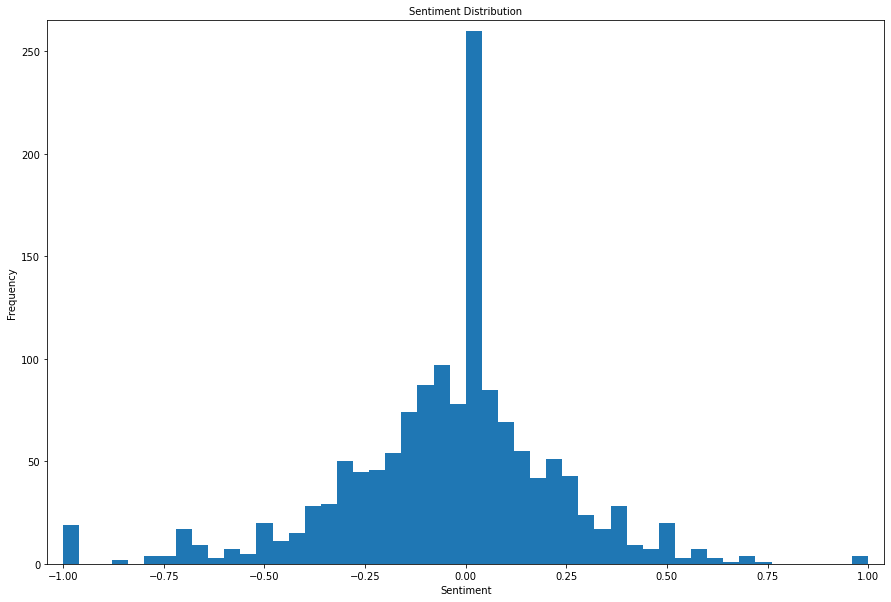

In [8]:
plt.figure(figsize=(15,10))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=10)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=10)
plt.show()

#### The graphic shows that there is slightly more positive sentiment, eventhough not certain. It is distributed around the center with normal distribution. 

#### _Discussion Point 4: Could other sentiment analysis methods be applied, such as naive bayes method?_

## EDA

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

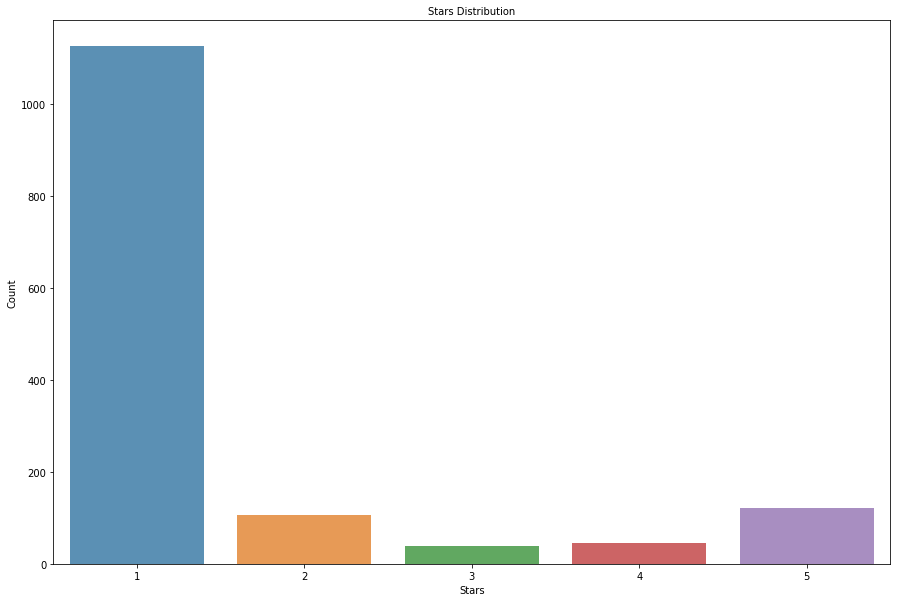

In [9]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.stars.value_counts().index, y=df.stars.value_counts(), alpha=0.8)
plt.title("Stars Distribution", fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Stars', fontsize=10)
plt.xticks(fontsize=10)

#### In the above graphic, we can see that the majority of comments are related with 1-star, and 5,2,4,3 respectively.

#### Calculated "letter_count" and "word_count" to be able to get the correlation between number of letter-word and star ranking

In [10]:
# Length of letters per text
df['letter_count'] = df['lemma_str'].astype(str).apply(len)

# Number of tokens/words per text
df['word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))
df

,stars,lemmatized,lemma_str,sentiment,letter_count,word_count
0,4,"[always, use, national, rail, enquiry, site, p...",always use national rail enquiry site plan rai...,0.333333,137,21
1,4,"[first, class, spacious, free, wireless, inter...",first class spacious free wireless internet fr...,0.379167,99,15
2,5,"[virgin, train, customer, service, amaze]",virgin train customer service amaze,0.000000,35,5
3,4,"[save, single, trip, use, nationalrail, pick, ...",save single trip use nationalrail pick specifi...,0.360317,113,17
4,5,"[travel, back, coventry, wolverhampton, statio...",travel back coventry wolverhampton station mis...,0.243452,150,22
...,...,...,...,...,...,...
1432,1,"[poor, service, chester, manchester, train, ov...",poor service chester manchester train overcrow...,-0.120000,220,30
1433,1,"[day, delay, swr, train, celebrate]",day delay swr train celebrate,0.000000,29,5
1434,1,"[terrible, service]",terrible service,-1.000000,16,2
1435,1,"[star, would, appropriate]",star would appropriate,0.500000,22,3


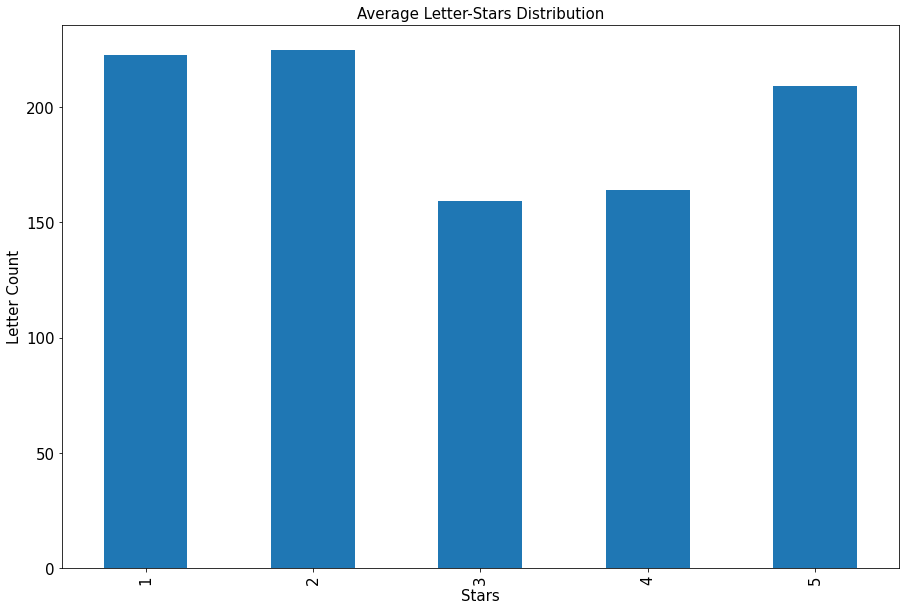

In [11]:
letter_avg = df.groupby('stars')['letter_count'].mean().plot(kind='bar', figsize=(15,10))
plt.xlabel('Stars', fontsize=15)
plt.ylabel('Letter Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Average Letter-Stars Distribution', fontsize=15)
plt.show()

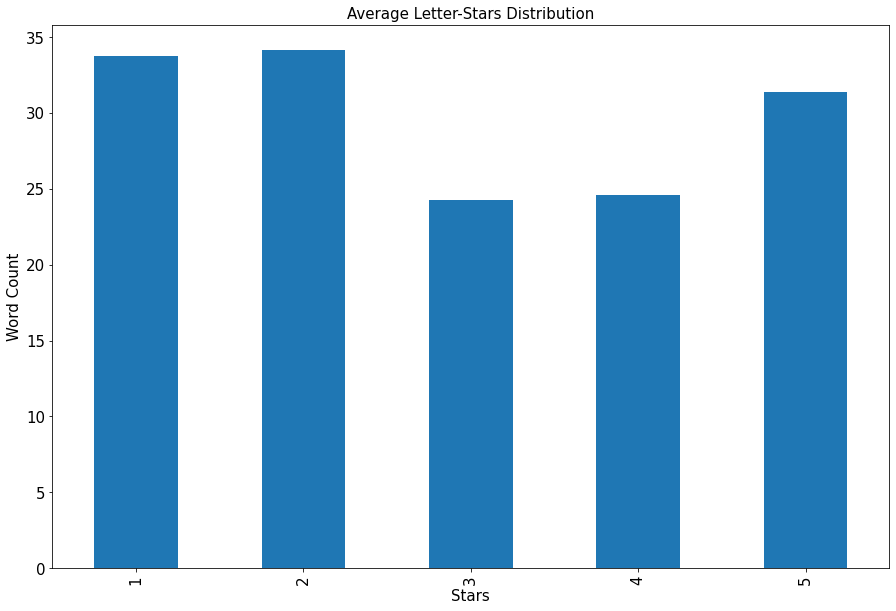

In [12]:
letter_avg = df.groupby('stars')['word_count'].mean().plot(kind='bar', figsize=(15,10))
plt.xlabel('Stars', fontsize=15)
plt.ylabel('Word Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Average Letter-Stars Distribution', fontsize=15)
plt.show()

<AxesSubplot:>

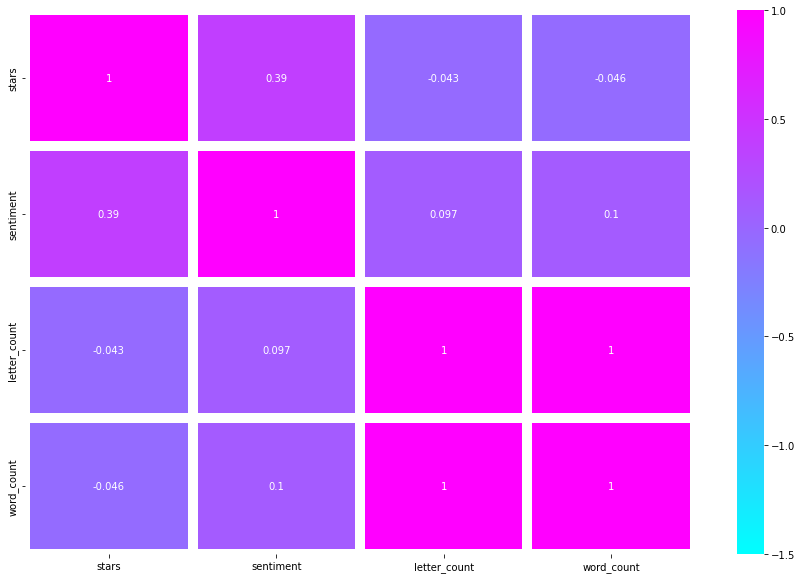

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(df[['stars','sentiment', 'letter_count', 'word_count']].corr(), cmap='cool', annot=True, linewidths=10, vmin=-1.5)

#### As a result, we see that there is no exact pos/neg correlation between sentiment/star and letter_count/word_count.
#### In other words, length of letters or words does not affect stars or sentiment in either positive or negative way.

## Word Frequencies

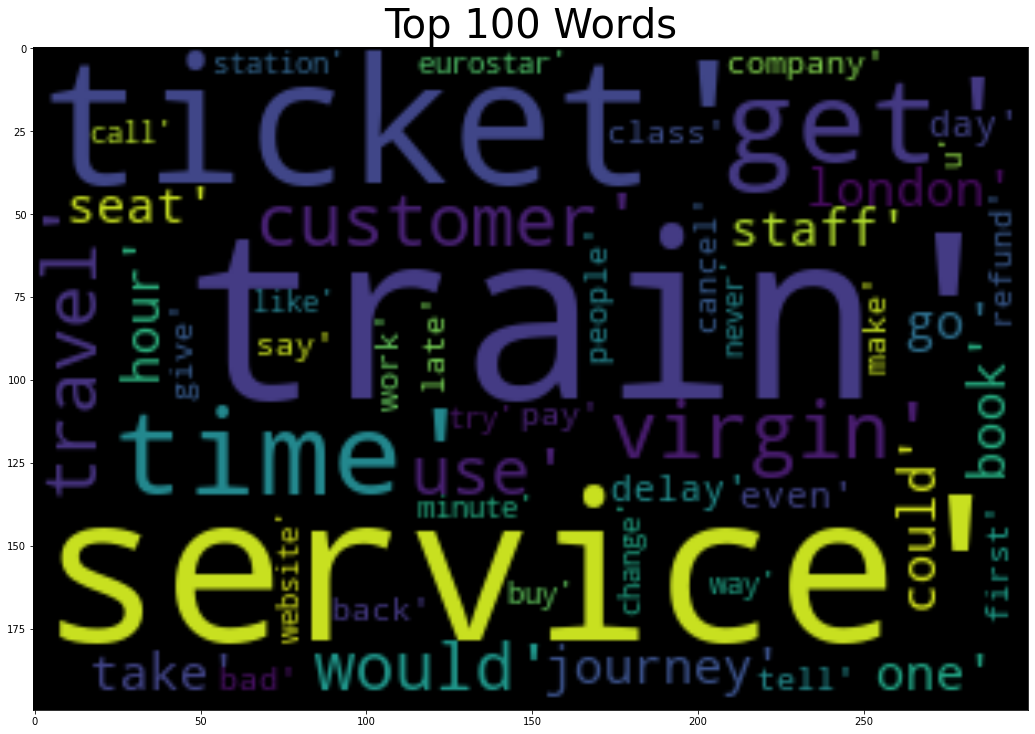

In [14]:
combined_word_list = list(df['lemmatized'].apply(pd.Series).stack())
most_common_words = FreqDist(combined_word_list).most_common(50)

wordcloud = WordCloud(width=300, height=200, background_color='black').generate(str(most_common_words))
fig = plt.figure(figsize=(15,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Top 100 Words', fontsize=40)

plt.tight_layout(pad=0)
plt.show()

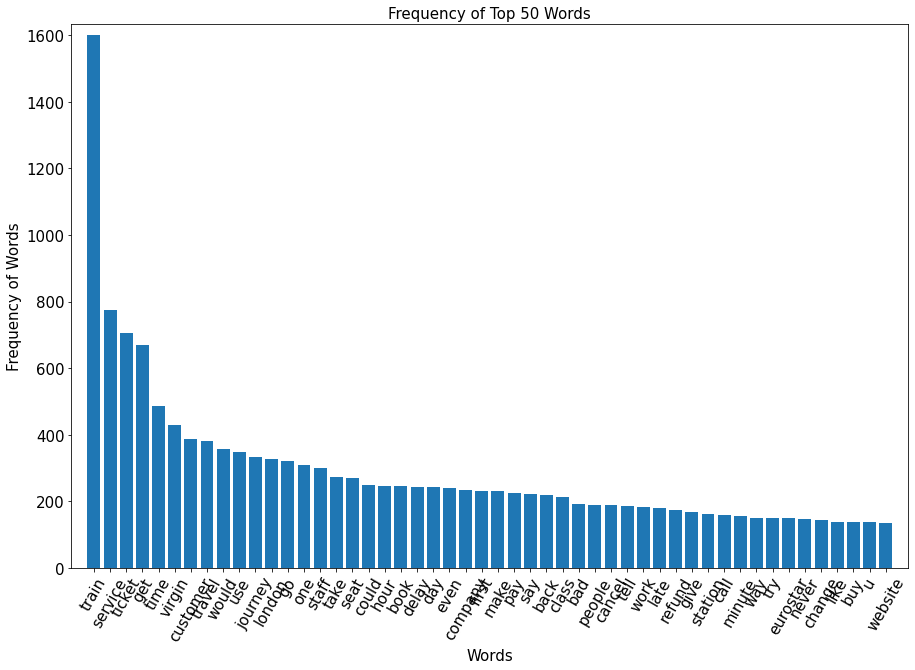

In [15]:
top_50 = FreqDist(combined_word_list).most_common(50)
x, y = zip(*top_50)
plt.figure(figsize=(15,10))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Frequency of Words', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of Top 50 Words', fontsize=15)
plt.show()

In [16]:
group_by = df.groupby('stars')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(50))
group_by_df = pd.DataFrame(group_by).reset_index()
group_by_df

,stars,lemma_str
0,1,"[(train, 1233), (ticket, 625), (service, 614),..."
1,2,"[(train, 123), (service, 47), (ticket, 46), (g..."
2,3,"[(train, 37), (travel, 14), (service, 14), (vi..."
3,4,"[(train, 31), (service, 23), (get, 22), (londo..."
4,5,"[(train, 177), (service, 76), (virgin, 51), (t..."


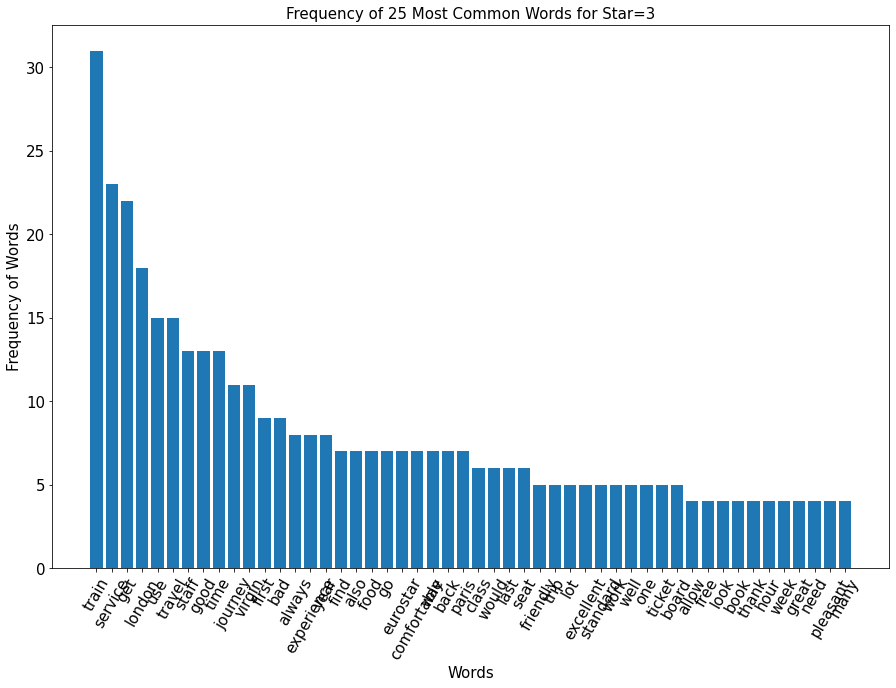

In [17]:
star = 3
group_by_chosen = group_by.iloc[star]
words = list(zip(*group_by_chosen))[0]
freq = list(zip(*group_by_chosen))[1]

plt.figure(figsize=(15,10))
plt.bar(words, freq)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Frequency of Words', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words for Star=%d'%(star), fontsize=15)
plt.show()

## Topic Modeling

#### In this section, I applied __Topic Modeling__ with two methods to compare output topics:
#### - LDA(Latend Dirichlet Allocation)
#### - NMF(Non-Negative Matrix Factorization)

## LDA

#### The __CountVectorizer__ method of vectorizing tokens transposes all the words/tokens into features and then provides a count of occurrence of each word. The result is called a document term matrix

In [18]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
cv_tf = count_vectorizer.fit_transform(df['lemma_str'].values.astype('U'))
count_vectorizer_feature_names = count_vectorizer.get_feature_names()
count_vectorizer_feature_names[:20]

['able',
 'absolute',
 'absolutely',
 'actually',
 'advance',
 'advise',
 'ago',
 'allow',
 'almost',
 'already',
 'also',
 'always',
 'another',
 'answer',
 'anyone',
 'anything',
 'appal',
 'around',
 'arrive',
 'ask']

In [20]:
# Each row representscounts of how many times each word occurs in each comment.
doc_term_matrix = pd.DataFrame(cv_tf.toarray(), columns=list(count_vectorizer_feature_names))
doc_term_matrix

,able,absolute,absolutely,actually,advance,advise,ago,allow,almost,already,...,wifi,without,work,worst,would,write,wrong,year,yet,york
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
# Create 10 topics by n_component=10
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(cv_tf)
print(lda_model)

LatentDirichletAllocation(learning_method='online', max_iter=500,
                          random_state=0)


In [22]:
no_top_words = 15
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, count_vectorizer_feature_names, no_top_words)

Topic 0:
seat train travel london virgin journey cross sit edinburgh reserve king year newcastle staff time
Topic 1:
service would use star help say train great review staff good work station one helpful
Topic 2:
refund delay email send two compensation claim reply month complaint week still journey wait form
Topic 3:
first class food journey travel way virgin pay drink st ticket standard london offer hot
Topic 4:
th may coach move system tell break reservation problem check total southern expect sort call
Topic 5:
staff eurostar customer ticket service rude phone ask say take receive unhelpful contact queue purchase
Topic 6:
train get time cancel late delay service hour go southern make london people rail work
Topic 7:
ticket get book train would time pay could tell buy change call take back even
Topic 8:
train virgin use company carriage service coast east never one people number always like return
Topic 9:
service customer bad experience ever care company terrible never awful money 

#### The keywords in topics are a bit ambigious

In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, cv_tf, count_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6      -69.256104 -124.349907       1        1  27.515423
7       -7.580594  105.134415       2        1  23.490021
5      202.540848   -7.390769       3        1   8.829632
8       89.216324   19.716000       4        1   7.926780
1     -117.988144   16.796785       5        1   7.838291
0      177.915024 -136.255127       6        1   7.185730
9      -12.916304  -21.241528       7        1   6.160401
3      130.486435  124.000694       8        1   5.945527
2       73.787598  -89.561287       9        1   3.863854
4       40.357681 -198.360550      10        1   1.244340, topic_info=           Term         Freq        Total Category  logprob  loglift
300       train  1573.000000  1573.000000  Default  30.0000  30.0000
255     service   785.000000   785.000000  Default  29.0000  29.0000
119       first   229.000000   229.000000  Default  28.0000  28.0000
77        delay   257.000000   257.000000  Default  27.0000  27.0000
250        seat   264.000000   264.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
287    terrible     0.133606    78.700378  Topic10  -7.9315  -1.9919
88          due     0.133590   120.575246  Topic10  -7.9316  -2.4187
99   eventually     0.133587    31.868159  Topic10  -7.9316  -1.0880
290       thing     0.133570    44.219929  Topic10  -7.9317  -1.4157
184        must     0.133563    30.814484  Topic10  -7.9318  -1.0546

[466 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         1  0.175134    absolute
1         3  0.125095    absolute
1         7  0.700534    absolute
2         1  0.421584  absolutely
2         4  0.159911  absolutely
...     ...       ...         ...
333       6  0.376423        year
333       7  0.140064        year
335       1  0.101018        york
335       6  0.681869        york
335       8  0.202035        york

[862 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 6, 9, 2, 1, 10, 4, 3, 5])

## NMF

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tf_idf = tfidf_vectorizer.fit_transform(df['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

doc_term_matrix_tfidf = pd.DataFrame(tf_idf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,able,absolute,absolutely,actually,advance,advise,ago,allow,almost,already,...,wifi,without,work,worst,would,write,wrong,year,yet,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.253481,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.534792,0.0,0.0,0.0,0.0,0.0


In [27]:
# Use nndsvd: Nonnegative Double Singular Value Decomposition for sparsness
nmf_model = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tf_idf)
display_topics(nmf_model, tfidf_feature_names, no_top_words)

Topic 0:
train late cancel delay get time minute always hour run station go make home wait
Topic 1:
class first st food travel journey edinburgh standard drink offer poor newcastle treat full second
Topic 2:
ticket buy pay website would get book go price use new tell could change online
Topic 3:
service customer terrible poor appal worst use shock awful horrible gwr great care ever absolutely
Topic 4:
virgin train use east coast euston travel book london king customer like cross route edinburgh
Topic 5:
company bad rail southern ever use experience railway never even run think one review start
Topic 6:
london travel eurostar year take paris time back experience trip journey manchester way go book
Topic 7:
seat reserve sit toilet get reservation train book carriage people stand hour even table pay
Topic 8:
staff rude helpful star say unhelpful station thank would member give help platform friendly passenger
Topic 9:
refund email delay get send reply call still day complaint journey mont

In [30]:
lda_topic_values = lda_model.transform(cv_tf)
df['lda_topics'] = lda_topic_values.argmax(axis=1)

nmf_topic_values = nmf_model.transform(tf_idf)
df['nmf_topics'] = nmf_topic_values.argmax(axis=1)

df

,stars,lemmatized,lemma_str,sentiment,letter_count,word_count,lda_topics,nmf_topics
0,4,"[always, use, national, rail, enquiry, site, p...",always use national rail enquiry site plan rai...,0.333333,137,21,7,5
1,4,"[first, class, spacious, free, wireless, inter...",first class spacious free wireless internet fr...,0.379167,99,15,3,1
2,5,"[virgin, train, customer, service, amaze]",virgin train customer service amaze,0.000000,35,5,8,4
3,4,"[save, single, trip, use, nationalrail, pick, ...",save single trip use nationalrail pick specifi...,0.360317,113,17,1,4
4,5,"[travel, back, coventry, wolverhampton, statio...",travel back coventry wolverhampton station mis...,0.243452,150,22,7,0
...,...,...,...,...,...,...,...,...
1432,1,"[poor, service, chester, manchester, train, ov...",poor service chester manchester train overcrow...,-0.120000,220,30,6,0
1433,1,"[day, delay, swr, train, celebrate]",day delay swr train celebrate,0.000000,29,5,6,0
1434,1,"[terrible, service]",terrible service,-1.000000,16,2,9,3
1435,1,"[star, would, appropriate]",star would appropriate,0.500000,22,3,1,8


In [31]:
lda_remap = {0: 'Topic 0', 1: 'Topic 1', 2: 'Topic 2', 3: 'Topic 3', 4: 'Topic 4', 
             5: 'Topic 5', 6: 'Topic 6', 7: 'Topic 7', 8: 'Topic 8', 9: 'Topic 9'}

df['lda_topics'] = df['lda_topics'].map(lda_remap)
df

,stars,lemmatized,lemma_str,sentiment,letter_count,word_count,lda_topics,nmf_topics
0,4,"[always, use, national, rail, enquiry, site, p...",always use national rail enquiry site plan rai...,0.333333,137,21,Topic 7,5
1,4,"[first, class, spacious, free, wireless, inter...",first class spacious free wireless internet fr...,0.379167,99,15,Topic 3,1
2,5,"[virgin, train, customer, service, amaze]",virgin train customer service amaze,0.000000,35,5,Topic 8,4
3,4,"[save, single, trip, use, nationalrail, pick, ...",save single trip use nationalrail pick specifi...,0.360317,113,17,Topic 1,4
4,5,"[travel, back, coventry, wolverhampton, statio...",travel back coventry wolverhampton station mis...,0.243452,150,22,Topic 7,0
...,...,...,...,...,...,...,...,...
1432,1,"[poor, service, chester, manchester, train, ov...",poor service chester manchester train overcrow...,-0.120000,220,30,Topic 6,0
1433,1,"[day, delay, swr, train, celebrate]",day delay swr train celebrate,0.000000,29,5,Topic 6,0
1434,1,"[terrible, service]",terrible service,-1.000000,16,2,Topic 9,3
1435,1,"[star, would, appropriate]",star would appropriate,0.500000,22,3,Topic 1,8


In [32]:
nmf_remap = {0: 'Topic 0', 1: 'Topic 1', 2: 'Topic 2', 3: 'Topic 3', 4: 'Topic 4', 
             5: 'Topic 5', 6: 'Topic 6', 7: 'Topic 7', 8: 'Topic 8', 9: 'Topic 9'}

df['nmf_topics'] = df['nmf_topics'].map(nmf_remap)
df

,stars,lemmatized,lemma_str,sentiment,letter_count,word_count,lda_topics,nmf_topics
0,4,"[always, use, national, rail, enquiry, site, p...",always use national rail enquiry site plan rai...,0.333333,137,21,Topic 7,Topic 5
1,4,"[first, class, spacious, free, wireless, inter...",first class spacious free wireless internet fr...,0.379167,99,15,Topic 3,Topic 1
2,5,"[virgin, train, customer, service, amaze]",virgin train customer service amaze,0.000000,35,5,Topic 8,Topic 4
3,4,"[save, single, trip, use, nationalrail, pick, ...",save single trip use nationalrail pick specifi...,0.360317,113,17,Topic 1,Topic 4
4,5,"[travel, back, coventry, wolverhampton, statio...",travel back coventry wolverhampton station mis...,0.243452,150,22,Topic 7,Topic 0
...,...,...,...,...,...,...,...,...
1432,1,"[poor, service, chester, manchester, train, ov...",poor service chester manchester train overcrow...,-0.120000,220,30,Topic 6,Topic 0
1433,1,"[day, delay, swr, train, celebrate]",day delay swr train celebrate,0.000000,29,5,Topic 6,Topic 0
1434,1,"[terrible, service]",terrible service,-1.000000,16,2,Topic 9,Topic 3
1435,1,"[star, would, appropriate]",star would appropriate,0.500000,22,3,Topic 1,Topic 8


## LDA Topic Distribution

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Topic 6'),
  Text(1, 0, 'Topic 7'),
  Text(2, 0, 'Topic 1'),
  Text(3, 0, 'Topic 0'),
  Text(4, 0, 'Topic 8'),
  Text(5, 0, 'Topic 3'),
  Text(6, 0, 'Topic 9'),
  Text(7, 0, 'Topic 5'),
  Text(8, 0, 'Topic 2'),
  Text(9, 0, 'Topic 4')])

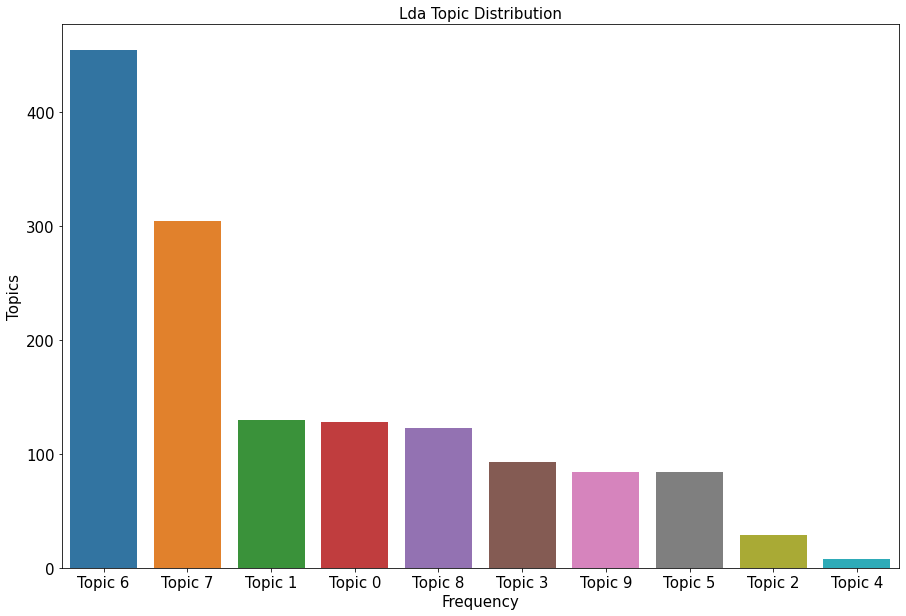

In [33]:
plt.figure(figsize=(15,10))
sns.barplot(x = df['lda_topics'].value_counts().index, y = df['lda_topics'].value_counts())
plt.title("Lda Topic Distribution", fontsize=15)
plt.ylabel('Topics', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)

In [34]:
df_low_stars = df.loc[(df['stars'] == 1) | (df['stars'] == 2) | (df['stars'] == 3)]
df_high_stars = df.loc[(df['stars'] == 4) | (df['stars'] == 5)]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Topic 6'),
  Text(1, 0, 'Topic 7'),
  Text(2, 0, 'Topic 8'),
  Text(3, 0, 'Topic 0'),
  Text(4, 0, 'Topic 9'),
  Text(5, 0, 'Topic 1'),
  Text(6, 0, 'Topic 3'),
  Text(7, 0, 'Topic 5'),
  Text(8, 0, 'Topic 2'),
  Text(9, 0, 'Topic 4')])

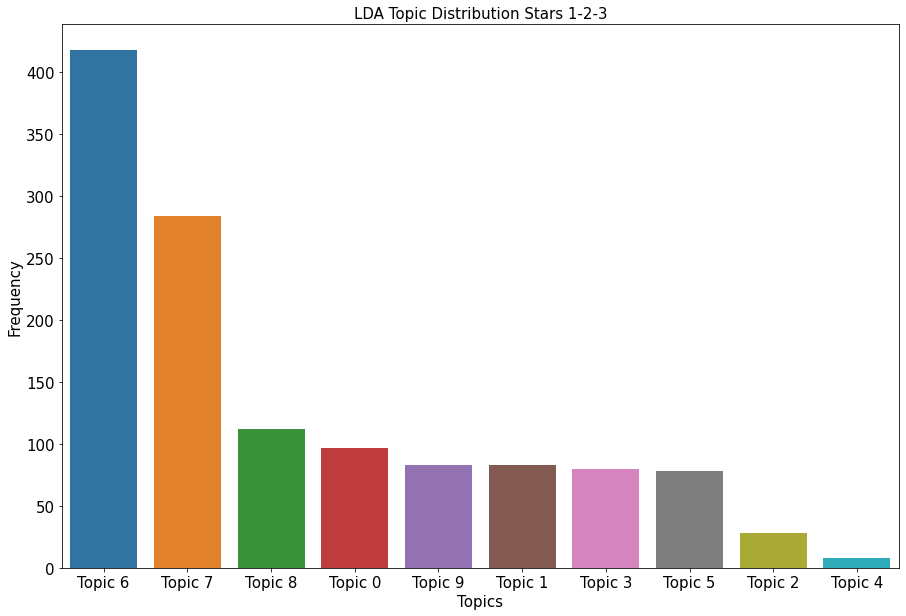

In [35]:
plt.figure(figsize=(15,10))
sns.barplot(x = df_low_stars['lda_topics'].value_counts().index, y = df_low_stars['lda_topics'].value_counts())
plt.title("LDA Topic Distribution Stars 1-2-3", fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Topics', fontsize=15)
plt.xticks(fontsize=15)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Topic 1'),
  Text(1, 0, 'Topic 6'),
  Text(2, 0, 'Topic 0'),
  Text(3, 0, 'Topic 7'),
  Text(4, 0, 'Topic 3'),
  Text(5, 0, 'Topic 8'),
  Text(6, 0, 'Topic 5'),
  Text(7, 0, 'Topic 2'),
  Text(8, 0, 'Topic 9')])

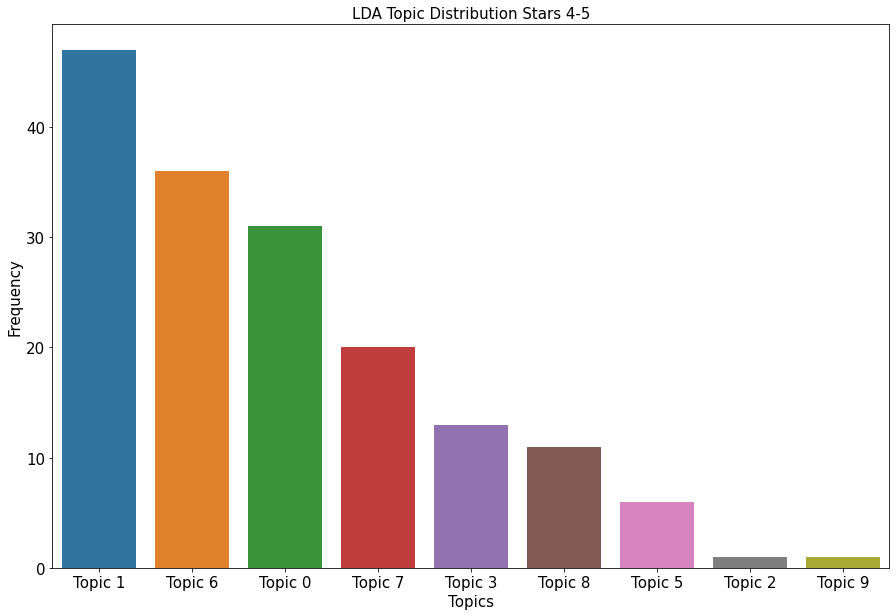

In [36]:
plt.figure(figsize=(15,10))
sns.barplot(x = df_high_stars['lda_topics'].value_counts().index, y = df_high_stars['lda_topics'].value_counts())
plt.title("LDA Topic Distribution Stars 4-5", fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Topics', fontsize=15)
plt.xticks(fontsize=15)

## NMF Topic Distribution

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Topic 0'),
  Text(1, 0, 'Topic 2'),
  Text(2, 0, 'Topic 3'),
  Text(3, 0, 'Topic 6'),
  Text(4, 0, 'Topic 9'),
  Text(5, 0, 'Topic 5'),
  Text(6, 0, 'Topic 8'),
  Text(7, 0, 'Topic 4'),
  Text(8, 0, 'Topic 1'),
  Text(9, 0, 'Topic 7')])

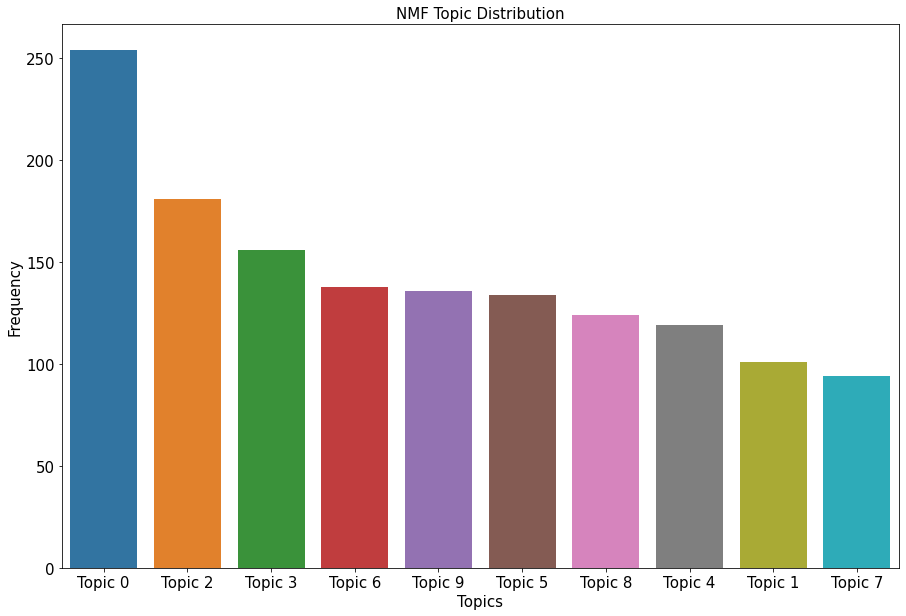

In [37]:
plt.figure(figsize=(15,10))
sns.barplot(x = df['nmf_topics'].value_counts().index, y = df['nmf_topics'].value_counts())
plt.title("NMF Topic Distribution", fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Topics', fontsize=15)
plt.xticks(fontsize=15)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Topic 0'),
  Text(1, 0, 'Topic 2'),
  Text(2, 0, 'Topic 3'),
  Text(3, 0, 'Topic 5'),
  Text(4, 0, 'Topic 9'),
  Text(5, 0, 'Topic 6'),
  Text(6, 0, 'Topic 8'),
  Text(7, 0, 'Topic 4'),
  Text(8, 0, 'Topic 7'),
  Text(9, 0, 'Topic 1')])

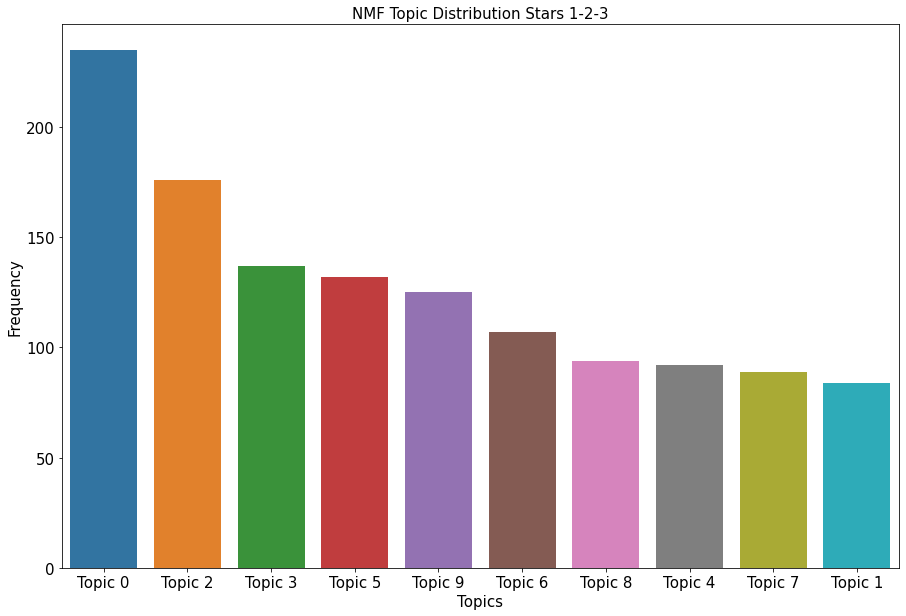

In [38]:
plt.figure(figsize=(15,10))
sns.barplot(x = df_low_stars['nmf_topics'].value_counts().index, y = df_low_stars['nmf_topics'].value_counts())
plt.title("NMF Topic Distribution Stars 1-2-3", fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Topics', fontsize=15)
plt.xticks(fontsize=15)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Topic 6'),
  Text(1, 0, 'Topic 8'),
  Text(2, 0, 'Topic 4'),
  Text(3, 0, 'Topic 0'),
  Text(4, 0, 'Topic 3'),
  Text(5, 0, 'Topic 1'),
  Text(6, 0, 'Topic 9'),
  Text(7, 0, 'Topic 7'),
  Text(8, 0, 'Topic 2'),
  Text(9, 0, 'Topic 5')])

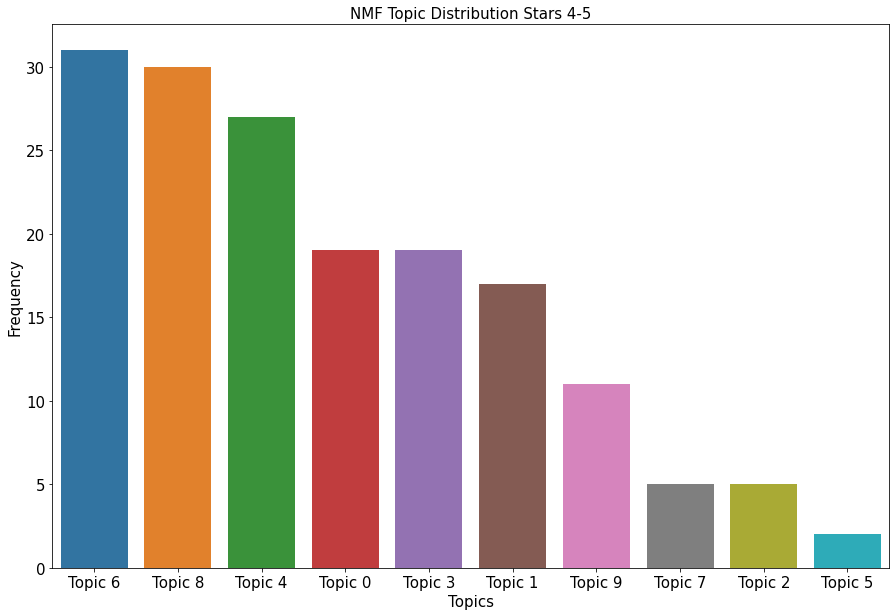

In [39]:
plt.figure(figsize=(15,10))
sns.barplot(x = df_high_stars['nmf_topics'].value_counts().index, y = df_high_stars['nmf_topics'].value_counts())
plt.title("NMF Topic Distribution Stars 4-5", fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Topics', fontsize=15)
plt.xticks(fontsize=15)

## CONCLUSION

#### In conclusion, NMF seems to give better and more distinguishable topics. In order to understand possible developments low star comments and topics should be analysed.

In [40]:
top_5_low_topics_nmf = df.loc[(df['nmf_topics'] == 'Topic 0') | (df['nmf_topics'] == 'Topic 2') | 
                              (df['nmf_topics'] == 'Topic 3') | (df['nmf_topics'] == 'Topic 5') | (df['nmf_topics'] == 'Topic 9')]
top_5_low_topics_nmf

,stars,lemmatized,lemma_str,sentiment,letter_count,word_count,lda_topics,nmf_topics
0,4,"[always, use, national, rail, enquiry, site, p...",always use national rail enquiry site plan rai...,0.333333,137,21,Topic 7,Topic 5
4,5,"[travel, back, coventry, wolverhampton, statio...",travel back coventry wolverhampton station mis...,0.243452,150,22,Topic 7,Topic 0
6,1,"[travel, brokenhast, southampton, central, wit...",travel brokenhast southampton central without ...,-0.107407,349,54,Topic 7,Topic 2
13,1,"[send, two, email, choose, ignore, typical, co...",send two email choose ignore typical company e...,-0.166667,76,11,Topic 2,Topic 5
17,1,"[recently, contact, customer, service, reply, ...",recently contact customer service reply curt u...,0.000000,160,21,Topic 5,Topic 3
...,...,...,...,...,...,...,...,...
1430,1,"[poor, use, service, time, many, bad, experien...",poor use service time many bad experience lose...,-0.228571,271,42,Topic 9,Topic 3
1432,1,"[poor, service, chester, manchester, train, ov...",poor service chester manchester train overcrow...,-0.120000,220,30,Topic 6,Topic 0
1433,1,"[day, delay, swr, train, celebrate]",day delay swr train celebrate,0.000000,29,5,Topic 6,Topic 0
1434,1,"[terrible, service]",terrible service,-1.000000,16,2,Topic 9,Topic 3


#### Topic 0: train, late, cancel, delay, get, time, minute, always, hour, run, station, go, make, home, wait
#### Topic 2: ticket, buy, pay, website, would, get, book, go, price, use, new, tell, could, change, online
#### Topic 3: service, customer, terrible, poor, appal, worst, use, shock, awful, horrible, gwr, great, care, ever, absolutely
#### Topic 5: company, bad, rail, southern, ever, use, experience, railway, never, even, run, think, one, review, start
#### Topic 9: refund, email, delay, get, send, reply, call, still, day, complaint, journey, month, phone, money, receive

In [41]:
top_5_low_topics_nmf.stars.value_counts()

1    739
2     50
5     40
4     16
3     16
Name: stars, dtype: int64

In [42]:
nmf_comments = read_format()
nmf_comments = format_data(nmf_comments)
nmf_comments = nmf_comments.loc[list(top_5_low_topics_nmf.index)]
nmf_comments

,date,title,text,stars
0,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,4
4,2015-02-11 13:20:32+00:00,Best customer service,I was at traveling back to Coventry from Wolve...,5
6,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,1
13,2015-05-22 04:30:06+00:00,No Customer Service Whatsoever,I have sent two emails to you but you have cho...,1
17,2015-06-15 18:48:35+00:00,Customer Service - a joke,I recently contacted customer services and the...,1
...,...,...,...,...
1430,2018-07-16 19:15:49+00:00,In the dark ages with customer service.,Very poor I have to use the service all the ti...,1
1432,2018-07-16 21:44:46+00:00,Overcrowded shoddy service,A very poor service on the Chester to Manchest...,1
1433,2018-07-17 08:51:36+00:00,the day we do not have delays in the…,the day we do not have delays in the SWR train...,1
1434,2018-07-17 08:54:14+00:00,Terrible service,Terrible service,1
